This notebook requires the library within `IAGA_SummerSchool2019/src/mag_lib` and data that has been manually stored in `IAGA_SummerSchool2019/data/external/ESK_2003`

In [1]:
import os
import sys
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("..")
from src import mag_lib as mag

# Load and merge 1-min data from one year

In [2]:
def load_year(obsy, year, dir_path):
    """Read in the daily 1-min files from a whole year.
    
    Args:
        obsy (str): Observatory code e.g. ESK
        year (int/str): Year
        dir_path (str): directory containing the files for that year
    
    Returns:
        DataFrame
    
    """
    dates_in_year = pd.date_range(
        start=f'{year}-01-01', end=f'{year}-12-31', freq='D'
    )
    df = pd.DataFrame()
    for date in dates_in_year:
        ymd = date.strftime('%Y%m%d')
        file_name = f'{obsy}{ymd}dmin.min'
        file_path = os.path.join(dir_path, file_name)
        df = df.append(mag.IAGA2002_Data_Reader(file_path))
    return df

df = load_year('esk', 2003, os.path.abspath('../data/external/ESK_2003'))
df.head()

,DOY,ESKX,ESKY,ESKZ,ESKF
DATE_TIME,,,,,
2003-01-01 00:00:00,1,17342.0,-1473.2,46197.8,49367.5
2003-01-01 00:01:00,1,17341.5,-1473.4,46197.8,49367.3
2003-01-01 00:02:00,1,17342.0,-1473.4,46197.8,49367.5
2003-01-01 00:03:00,1,17342.2,-1473.8,46197.6,49367.4
2003-01-01 00:04:00,1,17342.6,-1473.7,46197.6,49367.5


# Resample to 1-hour

In [3]:
df_h = df.resample('1h').mean()
df_h.head()

,DOY,ESKX,ESKY,ESKZ,ESKF
DATE_TIME,,,,,
2003-01-01 00:00:00,1,17342.540000,-1473.673333,46197.330000,49367.256667
2003-01-01 01:00:00,1,17344.796667,-1475.575000,46196.248333,49367.088333
2003-01-01 02:00:00,1,17344.376667,-1475.555000,46195.156667,49365.921667
2003-01-01 03:00:00,1,17348.140000,-1485.205000,46191.946667,49364.528333
2003-01-01 04:00:00,1,17352.800000,-1475.673333,46188.900000,49363.026667


# Change the index to a Bartels-rotation-based MultiIndex

In [4]:
def bartels_rotation(datetime, return_indexes=True):
    """
    
    Args:
        date (datetime/DatetimeIndex)
        
    Returns:
        tuple (rotation number, day within rotation, hour within day)
        
    """
    if type(datetime) is pd.DatetimeIndex:
        date, hour = datetime.date, datetime.hour
    elif type(datetime) is dt.datetime:
        date, hour = datetime.date(), datetime.hour
    # Number of days since Bartels 0
    ndays = pd.to_timedelta(date - dt.date(1832, 2, 8)).days
    bartels_rotation = ndays//27 + 1
    day = ndays%27 + 1
    if return_indexes:
        return bartels_rotation, day, hour
    else:
        return tuple([item.values for item in (bartels_rotation, day, hour)])


def create_bartels_index(df, nlevels=3):
    """Replaces a DatetimeIndex with a Bartels MultiIndex
    
    If nlevels is 3, the MultiIndex has levels:
        0: (bartrot) Bartel rotation number
        1: (bartrotday) Day within the current Bartel rotation
        2: (hourofday) Hour within the current day
    else if nlevels is 2:
        0: (bartrot) Bartel rotation number
        1: (bartrotday) Fractional day
    
    Args:
        df (DataFrame)
    
    Returns:
        DataFrame

    """
    bartrot, bartrotday, hourofday = bartels_rotation(df.index)
    if nlevels == 3:
        df.index = pd.MultiIndex.from_arrays(
            (bartrot, bartrotday, hourofday), names=("bartrot", "bartrotday", "hourofday")
        )
    elif nlevels == 2:
        df.index = pd.MultiIndex.from_arrays(
            (bartrot, bartrotday + hourofday/24), names=("bartrot", "bartrotday")
        )
    else:
        raise NotImplementedError()
    return df

In [5]:
bartrot, bartrotday, hourofday = bartels_rotation(df_h.index)
bartrot.values, bartrotday.values, hourofday.values

(array([2312, 2312, 2312, ..., 2326, 2326, 2326]),
 array([23, 23, 23, ...,  9,  9,  9]),
 array([ 0,  1,  2, ..., 21, 22, 23]))

In [6]:
create_bartels_index(df_h).head()

DOY          ESKX         ESKY          ESKZ  \
bartrot bartrotday hourofday                                                 
2312    23         0            1  17342.540000 -1473.673333  46197.330000   
                   1            1  17344.796667 -1475.575000  46196.248333   
                   2            1  17344.376667 -1475.555000  46195.156667   
                   3            1  17348.140000 -1485.205000  46191.946667   
                   4            1  17352.800000 -1475.673333  46188.900000   

                                      ESKF  
bartrot bartrotday hourofday                
2312    23         0          49367.256667  
                   1          49367.088333  
                   2          49365.921667  
                   3          49364.528333  
                   4          49363.026667

# Chaining pandas methods to create the plot directly

For the more complicated plot that is required, I don't know if this approach is possible...

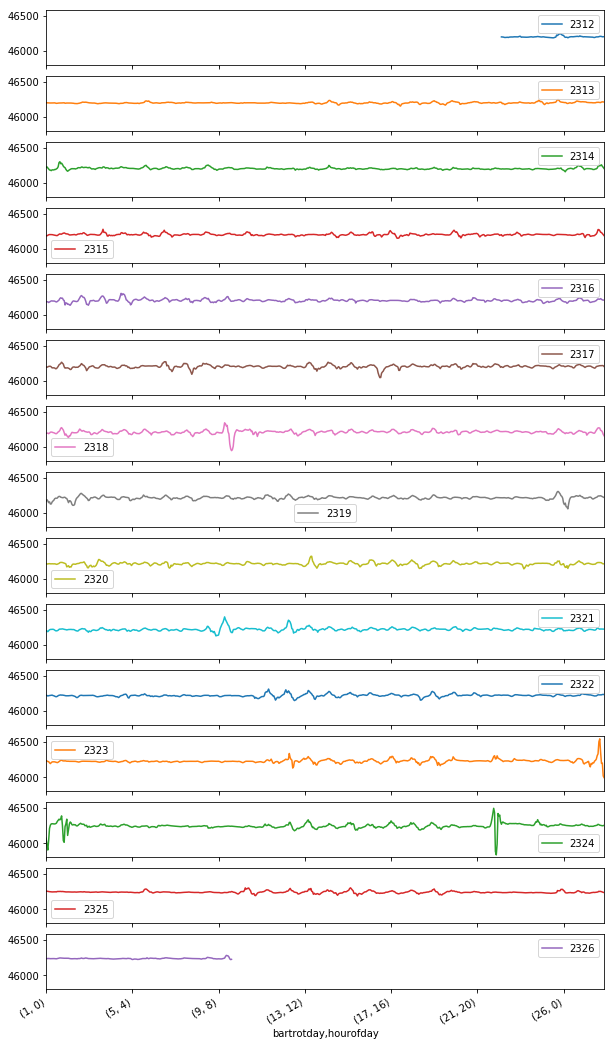

In [7]:
(df
 .resample('1h').mean()
 .pipe(create_bartels_index)
 .unstack(level=0)
 .plot(y="ESKZ", subplots=True, figsize=(10,20), sharey=True)
);

# Use a two-level index, and append annual means

In [8]:
obs = "ESK"
df_b = (
    df
    .resample('1h').mean()
)
annual_means = (
    df[[f"{obs}{i}" for i in "XYZF"]].resample("1Y").mean()
    .rename(columns={f"{obs}{i}":f"{obs}{i}_mean" for i in "XYZF"})
    .reindex(index=df_b.index, method="nearest")
)
df_b = df_b.join(annual_means)
# Preserve the time index as a column instead
df_b["time"] = df_b.index#.to_pydatetime()
df_b = create_bartels_index(df_b, nlevels=2)

df_b.head()

DOY          ESKX         ESKY          ESKZ  \
bartrot bartrotday                                                 
2312    23.000000     1  17342.540000 -1473.673333  46197.330000   
        23.041667     1  17344.796667 -1475.575000  46196.248333   
        23.083333     1  17344.376667 -1475.555000  46195.156667   
        23.125000     1  17348.140000 -1485.205000  46191.946667   
        23.166667     1  17352.800000 -1475.673333  46188.900000   

                            ESKF     ESKX_mean    ESKY_mean     ESKZ_mean  \
bartrot bartrotday                                                          
2312    23.000000   49367.256667  17337.347456 -1444.378883  46215.321921   
        23.041667   49367.088333  17337.347456 -1444.378883  46215.321921   
        23.083333   49365.921667  17337.347456 -1444.378883  46215.321921   
        23.125000   49364.528333  17337.347456 -1444.378883  46215.321921   
        23.166667   49363.026667  17337.347456 -1444.378883  46215.321921   

                      ESKF_mean                time  
bartrot bartrotday                                   
2312    23.000000   49381.42141 2003-01-01 00:00:00  
        23.041667   49381.42141 2003-01-01 01:00:00  
        23.083333   49381.42141 2003-01-01 02:00:00  
        23.125000   49381.42141 2003-01-01 03:00:00  
        23.166667   49381.42141 2003-01-01 04:00:00

In [9]:
# How to identify calendar month starts
month_starts = df_b["time"].where(
    (df_b["time"].dt.day == 1) & (df_b["time"].dt.hour == 0)
).dropna()
month_starts

bartrot  bartrotday
2312     23.0         2003-01-01
2313     27.0         2003-02-01
2315     1.0          2003-03-01
2316     5.0          2003-04-01
2317     8.0          2003-05-01
2318     12.0         2003-06-01
2319     15.0         2003-07-01
2320     19.0         2003-08-01
2321     23.0         2003-09-01
2322     26.0         2003-10-01
2324     3.0          2003-11-01
2325     6.0          2003-12-01
Name: time, dtype: datetime64[ns]

In [10]:
month_starts.loc[2312].dt.strftime("%b").values[0]

'Jan'

# Loop through each bartrot and plot it on its own axis

see http://geomag.bgs.ac.uk/data_service/data/bulletins/esk/2003/esk_dec03.pdf

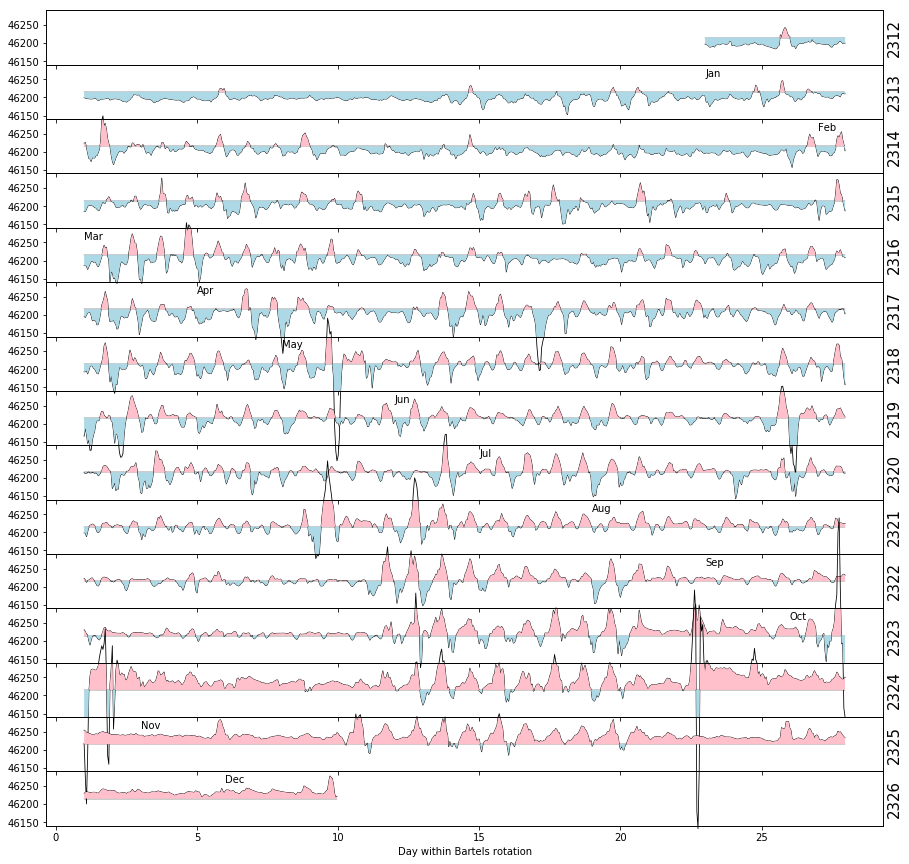

In [11]:
obs = "ESK"
var = "Z"

bartrots = range(df_b.index[0][0], df_b.index[-1][0] + 1)
fig, axes = plt.subplots(
    nrows=len(bartrots), ncols=1, figsize=(15, 15),
    gridspec_kw = {'hspace':0},
    sharex=True, sharey=True
)
for bartrot, ax in zip(bartrots, axes):
    x = df_b.loc[bartrot].index
    y0 = df_b.loc[bartrot][f"{obs}{var}_mean"]
    y1 = df_b.loc[bartrot][f"{obs}{var}"]
    ax.plot(x, y0, color="black", linewidth=0.4)
    ax.plot(x, y1, color="black", linewidth=0.8, clip_on=False)
    ax.fill_between(
        x, y0, y1, where=y1 < y0,
        facecolor='lightblue', interpolate=True, zorder=9#, clip_on=False currently causes a bug
    )
    ax.fill_between(
        x, y0, y1, where=y1 >= y0,
        facecolor='pink', interpolate=True, zorder=10#, clip_on=False
    )
    ax_r = ax.twinx()
    ax_r.set_ylabel(bartrot, fontsize=15)
    ax_r.set_yticks([])
    # some magic which enables lines from one axis to show on top of other axes
    ax.patch.set_visible(False)
    
    # Add text identifying the start of each month
    if bartrot in month_starts.keys():
        bartrotday = float(month_starts.loc[bartrot].index.values)
        month = month_starts.loc[bartrot].dt.strftime("%b").values[0]
        ax.text(bartrotday, y0.iloc[0] - 85, month, verticalalignment="top")

ax.set_ylim((y0.iloc[0] - 75, y0.iloc[0] + 75))
ax.set_xlabel("Day within Bartels rotation");